# Part 3.1: The synthetic data

In [ ]:
import torch

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
torch.cuda.is_available()

True

Create the synthetic data

In [ ]:
randrand=np.random.uniform(low=0.0, high=1.0, size=(10000,50))
newRandRand=[]
for i in range(50):
  seq=randrand[i,:]
  idx=np.random.randint(0,4)
  for j in range(idx-1,idx+1):
    seq[j]=seq[j]*0.0001
    newRandRand.append(seq)
newRandRand

# plt.figure()
# plt.title("Signal")
# plt.plot(newRandRand[0],label="Signal batch")
# plt.show()

r = pd.DataFrame(newRandRand, columns=[f"x_{i:02}" for i in range(50)])
train_set, test_set = train_test_split(r, test_size=0.4)
val_set, test_set = train_test_split(test_set, test_size=0.5)
val_set.to_csv("drive/MyDrive/Colab Notebooks/toy_val.csv", index=False)
test_set.to_csv("drive/MyDrive/Colab Notebooks/toy_test.csv", index=False)
train_set.to_csv("drive/MyDrive/Colab Notebooks/toy_train.csv", index=False)

Create the model

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import math
import random

In [ ]:
class encoder_decoder_toyModel(nn.Module):
    def __init__(self, hidden_n,seq_size):
        super().__init__()
        self.encoder=nn.LSTM(1,hidden_n,batch_first=True)
        self.decoder=nn.LSTM(hidden_n,hidden_n,batch_first=True)
        self.linear=nn.Linear(hidden_n,1)
        self.seq_size=seq_size
        self.hidden_n=hidden_n

    def forward(self,x):
        _,(all_hidden,_)=self.encoder(x)
        last_hidden=all_hidden.view(-1,1,self.hidden_n)
        last_h_rep=last_hidden.repeat(1,self.seq_size,1)
        Y_out,_ = self.decoder(last_h_rep)
        outFromLinear=self.linear(Y_out)
        return outFromLinear


In [ ]:
class train_toyModel():
    def __init__(self,
                 data,validationData,
                 sequenceLength,
                 batchSize,hiddenSize,learningRate,gradientClipping,gradientClippingValue,numberOfIterations,
                 sgd_string="Adam",MSE_string="MSE"):
        self.bsz=batchSize
        self.hiddenSize=hiddenSize
        self.lr=learningRate
        self.bsz=batchSize
        self.clip=gradientClipping
        self.clipVal=gradientClippingValue
        self.iters=numberOfIterations

        self.ae=encoder_decoder_toyModel(self.hiddenSize,sequenceLength)

        if(sgd_string=="sgd"):
            self.optim=optim.SGD(self.ae.parameters(),self.lr)
        else:
            self.optim=optim.Adam(self.ae.parameters(),self.lr)

        self.x_data=data
        self.validationData=validationData
        self.MES_string=MSE_string

    def train(self):
        trainingLosses=[]
        validationLosses=[]

        GPU_or_CPU=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.GPU_or_CPU=GPU_or_CPU
        if(GPU_or_CPU!="cpu"):
          print(f"working on GPU:{GPU_or_CPU}")
        self.ae.to(GPU_or_CPU)
        for i in range(self.iters):
            curr_loss=0
            for batch in self.x_data:
                self.optim.zero_grad()
                currBatch=batch.to(GPU_or_CPU)
                aeOut=self.ae.forward(currBatch)
                calc_andGetLoss=0
                if(self.MES_string=="MSE"):
                    calc_andGetLoss=nn.MSELoss().forward(aeOut,currBatch)
                calc_andGetLoss.backward() # calculate gradients
                self.optim.step()
                curr_loss+=calc_andGetLoss.item()
            avgLossForIter=curr_loss/len(self.x_data)
            trainingLosses.append(avgLossForIter)
            print(f"Iteration={i+1}, TrainLoss={avgLossForIter}")
        return trainingLosses,validationLosses
    
    def inference(self,data):
      dataOnDevice=data.to(self.GPU_or_CPU).unsqueeze(0)
      output=self.ae.forward(dataOnDevice)
      return output

Running on default parameters

In [ ]:
#define the parameters
p_BatchSize=64
p_HiddenStateSize=100
p_LearningRate=0.001
p_GradienClipping=False
p_GradientClippingValue=0.1
p_NumberOfIterations=200
p_SequenceLenght=50

Load the data

In [ ]:
class LoadedData(Dataset):
  def __init__(self,tensorDataSet):
    self.data=np.expand_dims(tensorDataSet,2).astype(np.float32)
  def __getitem__(self,idx):
    return self.data[idx]
  def __len__(self):
    return len(self.data)

In [ ]:
def load_data(path,bsz,shouldShuffle):
    tensorDataSet=pd.read_csv(path)
    dataObject=LoadedData(tensorDataSet)
    data_l=DataLoader(dataObject,batch_size=bsz,shuffle=shouldShuffle)
    return data_l

In [ ]:
x_data=load_data("drive/MyDrive/Colab Notebooks/toy_train.csv",p_BatchSize,True)
val_data=load_data("drive/MyDrive/Colab Notebooks/toy_val.csv",p_BatchSize,False)
test_data=load_data("drive/MyDrive/Colab Notebooks/toy_test.csv",p_BatchSize,False)

Show some of the signals

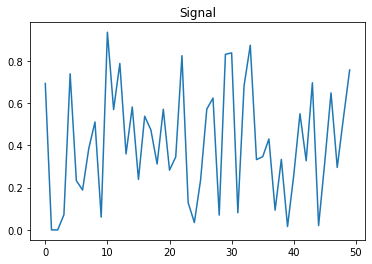

In [ ]:
plt.figure()
plt.title("Signal")
x_print=random.choice(next(iter(x_data)))
signal=[]
for i in range(p_SequenceLenght):
  signal.append(x_print.numpy()[i])
plt.plot(signal,label="Signal batch")
plt.show()

Running the model to reconstruct the synthetic data

In [ ]:
theTrainer=train_toyModel(x_data,val_data,p_SequenceLenght,p_BatchSize,p_HiddenStateSize,p_LearningRate,p_GradienClipping,p_GradientClippingValue,p_NumberOfIterations)
trainLosses,validationLosses=theTrainer.train()

working on GPU:cuda
Iteration=1, TrainLoss=0.09538509221153056
Iteration=2, TrainLoss=0.08220720465512986
Iteration=3, TrainLoss=0.0815086342552875
Iteration=4, TrainLoss=0.08150462156280558
Iteration=5, TrainLoss=0.08150484143419469
Iteration=6, TrainLoss=0.0815040889255544
Iteration=7, TrainLoss=0.08149731531739235
Iteration=8, TrainLoss=0.08150517425321518
Iteration=9, TrainLoss=0.08149978629452118
Iteration=10, TrainLoss=0.08149226731125345
Iteration=11, TrainLoss=0.0814966118716179
Iteration=12, TrainLoss=0.08150155763042734
Iteration=13, TrainLoss=0.08149694326393148
Iteration=14, TrainLoss=0.08149091439678315
Iteration=15, TrainLoss=0.08148754102752563
Iteration=16, TrainLoss=0.08150105780743538
Iteration=17, TrainLoss=0.08149949072840366
Iteration=18, TrainLoss=0.08149587331300086
Iteration=19, TrainLoss=0.0814994548229461
Iteration=20, TrainLoss=0.08150773836260146
Iteration=21, TrainLoss=0.08149180260110409
Iteration=22, TrainLoss=0.08149269548185328
Iteration=23, TrainLoss=0

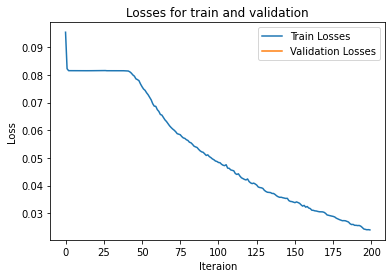

In [ ]:
plt.figure()
plt.title("Losses for train and validation")
plt.plot(trainLosses,label="Train Losses")
plt.plot(validationLosses,label="Validation Losses")
plt.xlabel("Iteraion")
plt.ylabel("Loss")
plt.legend()
plt.show()

Reconstruct from validation data

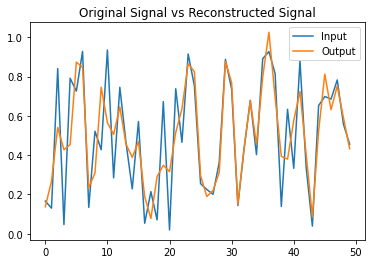

In [ ]:
plt.figure()
plt.title("Original Signal vs Reconstructed Signal")
original_val_batch=random.choice(next(iter(val_data)))
signal=[]
for i in range(p_SequenceLenght):
  signal.append(original_val_batch.numpy()[i])
plt.plot(signal,label="Input")
outputFromModel=theTrainer.inference(original_val_batch)
output = outputFromModel.cpu().detach().numpy().squeeze(0)
plt.plot(output, label="Output")
plt.legend()
plt.show()